=== 데이터 정보 ===
데이터 형태: (242378, 35)
발전구분별 분포: 발전구분
한경풍력    173284
성산풍력     45742
상명풍력     15285
어음풍력      8067
Name: count, dtype: int64
호기별 분포: 호기
1    131948
2    110430
Name: count, dtype: int64

=== 발전효율 통계 ===
발전효율 범위: 0.00% ~ 100.00%
발전효율 평균: 22.72%
발전효율 중앙값: 12.62%

=== 발전구분-호기 조합 ===
한경풍력_2호기: 87,632건
한경풍력_1호기: 85,652건
성산풍력_1호기: 22,944건
성산풍력_2호기: 22,798건
상명풍력_1호기: 15,285건
어음풍력_1호기: 8,067건

=== 시간대별 발전효율 데이터 생성 완료 ===
시간대별 효율 데이터 형태: (144, 3)


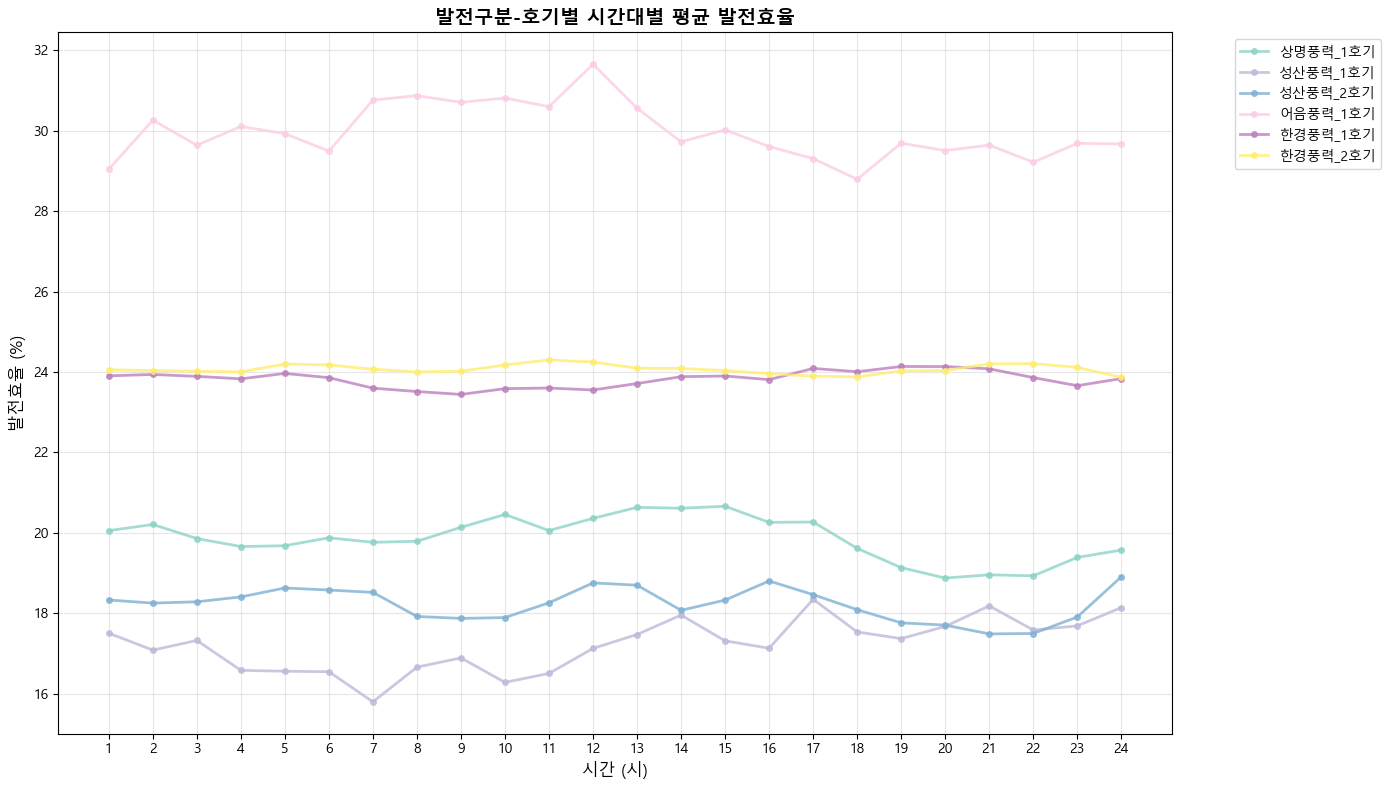


=== 발전구분-호기별 발전효율 통계 ===
          count   mean    std  min     max
발전구분_호기                                   
상명풍력_1호기  15285  19.87  21.81  0.0   95.76
성산풍력_1호기  22944  17.22  26.12  0.0  100.00
성산풍력_2호기  22798  18.23  27.81  0.0  100.00
어음풍력_1호기   8067  29.97  32.79  0.0   97.30
한경풍력_1호기  85652  23.83  25.79  0.0  100.00
한경풍력_2호기  87632  24.07  25.06  0.0  100.00

=== 시간대별 효율 분석 ===
최고 효율 시간: 17시 (22.88%)
최저 효율 시간: 8시 (22.53%)

=== 발전구분별 최고 효율 시간 ===
어음풍력: 12시 (31.65%)
상명풍력: 15시 (20.66%)
한경풍력: 21시 (24.14%)
성산풍력: 24시 (18.53%)

=== EDA 완료 ===
발전구분-호기별 시간대별 발전효율 분석이 완료되었습니다.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('../전처리_과정_데이터/전처리완료_기상과풍력.csv')

print("=== 데이터 정보 ===")
print(f"데이터 형태: {df.shape}")
print(f"발전구분별 분포: {df['발전구분'].value_counts()}")
print(f"호기별 분포: {df['호기'].value_counts().sort_index()}")

# 발전효율 계산 (발전량(kWh) / (설비용량(MW) * 1000) * 100)
df['발전효율(%)'] = (df['발전량(kWh)'] / (df['설비용량(MW)'] * 1000)) * 100

print(f"\n=== 발전효율 통계 ===")
print(f"발전효율 범위: {df['발전효율(%)'].min():.2f}% ~ {df['발전효율(%)'].max():.2f}%")
print(f"발전효율 평균: {df['발전효율(%)'].mean():.2f}%")
print(f"발전효율 중앙값: {df['발전효율(%)'].median():.2f}%")

# 발전구분-호기 조합 생성
df['발전구분_호기'] = df['발전구분'] + '_' + df['호기'].astype(str) + '호기'

print(f"\n=== 발전구분-호기 조합 ===")
plant_unit_counts = df['발전구분_호기'].value_counts()
for plant_unit, count in plant_unit_counts.items():
    print(f"{plant_unit}: {count:,}건")

# 시간_sin을 다시 시간으로 변환 (0~23시)
# sin((hour-1) * 2π / 24) 역변환
df['시간'] = np.round((np.arcsin(df['시간_sin']) * 24 / (2 * np.pi)) + 1)
# sin 함수의 특성상 정확한 역변환이 어려우므로, 대신 0~23으로 매핑
df['시간'] = df.groupby(df.index // (len(df) // 24 + 1)).cumcount() % 24 + 1

# 시간대별 평균 발전효율 계산
hourly_efficiency = df.groupby(['발전구분_호기', '시간'])['발전효율(%)'].mean().reset_index()

print(f"\n=== 시간대별 발전효율 데이터 생성 완료 ===")
print(f"시간대별 효율 데이터 형태: {hourly_efficiency.shape}")

# 시각화: 발전구분-호기별 시간대별 발전효율 꺾은선 그래프
plt.figure(figsize=(14, 8))

# 색상 팔레트 설정 (발전구분-호기별로 구분)
unique_plants = hourly_efficiency['발전구분_호기'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(unique_plants)))
color_dict = dict(zip(unique_plants, colors))

# 발전구분-호기별 시간대별 발전효율 꺾은선 그래프
for plant_unit in unique_plants:
    plant_data = hourly_efficiency[hourly_efficiency['발전구분_호기'] == plant_unit]
    plt.plot(plant_data['시간'], plant_data['발전효율(%)'], 
             marker='o', linewidth=2, markersize=4, 
             color=color_dict[plant_unit], label=plant_unit, alpha=0.8)

plt.xlabel('시간 (시)', fontsize=12)
plt.ylabel('발전효율 (%)', fontsize=12)
plt.title('발전구분-호기별 시간대별 평균 발전효율', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 25))
plt.tight_layout()
plt.show()

# 상세 통계 출력
print(f"\n=== 발전구분-호기별 발전효율 통계 ===")
efficiency_stats = df.groupby('발전구분_호기')['발전효율(%)'].agg(['count', 'mean', 'std', 'min', 'max'])
print(efficiency_stats.round(2))

# 시간대별 최고/최저 효율 시간 찾기
print(f"\n=== 시간대별 효율 분석 ===")
hourly_avg = df.groupby('시간')['발전효율(%)'].mean()
max_hour = hourly_avg.idxmax()
min_hour = hourly_avg.idxmin()
print(f"최고 효율 시간: {max_hour}시 ({hourly_avg[max_hour]:.2f}%)")
print(f"최저 효율 시간: {min_hour}시 ({hourly_avg[min_hour]:.2f}%)")

# 발전구분별 최고 효율 시간
print(f"\n=== 발전구분별 최고 효율 시간 ===")
for plant in df['발전구분'].unique():
    plant_hourly = df[df['발전구분'] == plant].groupby('시간')['발전효율(%)'].mean()
    max_hour = plant_hourly.idxmax()
    max_eff = plant_hourly[max_hour]
    print(f"{plant}: {max_hour}시 ({max_eff:.2f}%)")

print("\n=== EDA 완료 ===")
print("발전구분-호기별 시간대별 발전효율 분석이 완료되었습니다.")

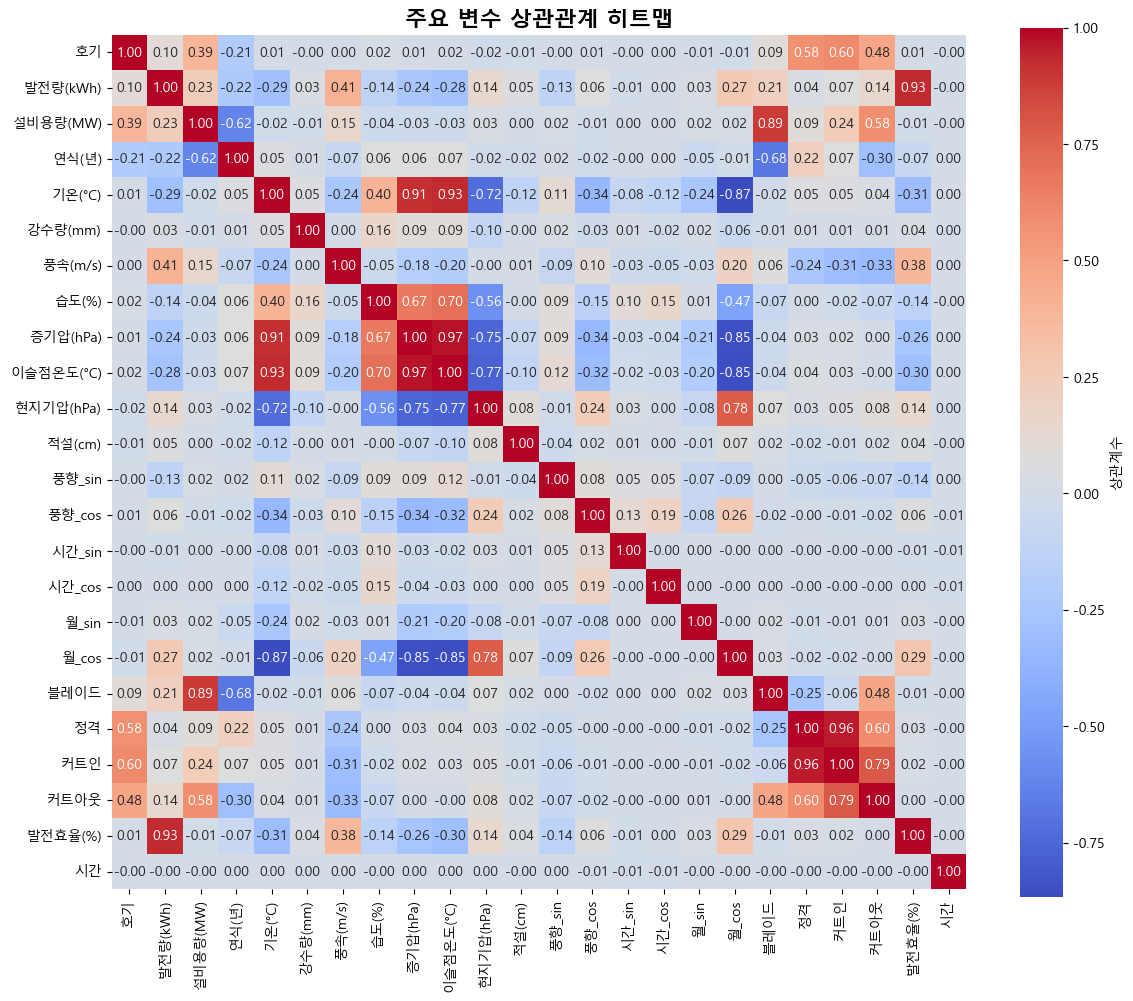

In [3]:
# 상관관계 분석: 히트맵 하나만 출력
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rc('axes', unicode_minus=False)

# 수치형 컬럼만 추출
corr_cols = df.select_dtypes(include=[float, int]).columns
corr = df[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'label': '상관계수'})
plt.title('주요 변수 상관관계 히트맵', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()